# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation, utils
from scipy import fftpack
from matplotlib import pyplot as plt
from enum import Enum, auto


### Regular simulation settings

In [2]:
amplitude = 10000
sim_wavelength = 488e-9
sim_width = 1500e-6
# pixel_size = 0.1e-6
pixel_size = 1e-6
output_medium = Lens.Medium(1.33)

### Convergence/Divergence Class/Functions

In [3]:
class BeamSpread(Enum):
    Plane = auto()
    Diverging = auto()
    Converging = auto()

class DistanceMode(Enum):
    Direct = auto()
    Width = auto()
    Focal = auto()

class BeamShape(Enum):
    Circular = auto()
    Square = auto()
    Rectangular = auto()

def theta_from_NA(numerical_aperture: float, output_medium: Lens.Medium):
    import numpy as np
    return np.arcsin(numerical_aperture/output_medium.refractive_index)

def focal_distance_from_theta(beam: Lens, theta: float):
    return beam.diameter/2 / np.tan(theta)

def height_from_focal_distance(beam: Lens, output_medium: Lens.Medium, focal_distance: float):
    a = 1
    b = -2*focal_distance*(beam.medium.refractive_index-output_medium.refractive_index)/output_medium.refractive_index
    c = (beam.diameter/2)**2

    if (b**2 - 4*a*c < 0):
        raise ValueError("Negative value encountered in sqrt.  Can't find a lens height to give this focal distance")
    else: return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

### Config Beam Definition

In [22]:
# Beam settings chosen by user
beam_width = 15e-6
beam_height = 5e-6
# beam_width = 150e-6
# beam_height = 50e-6
beam_width = 500e-6
beam_height = 150e-6
beam_position = [-300e-6, 200e-6]
beam_position = [-0e-6, 0e-6]

# this is selected by DistanceMode flag in config
distance_mode = DistanceMode.Direct

# type of beam spread
beam_spread = BeamSpread.Plane

# type of beam shape
beam_shape = BeamShape.Square

if beam_shape is not BeamShape.Rectangular:
    beam_height = beam_width

if beam_spread is BeamSpread.Plane:
    distance_mode = DistanceMode.Direct

# can't do converging/diverging square case
if beam_spread is not BeamSpread.Plane:
    beam_shape = BeamShape.Circular

    # Theta can either be specified directly, or by numerical aperture (config flag probably)
    theta = np.deg2rad(10) 
    # OR
    # theta = theta_from_NA(numerical_aperture=0.4, output_medium=output_medium)

# perpendicular distance of source from the first lens can be defined directly (aperture distance) 
# or based on a desired beam width at the lens plane 
source_aperture_distance = 20000e-6
final_beam_width = 800e-6
if beam_spread is BeamSpread.Plane:
    final_beam_width = beam_width

# Default beam specifications
beam = Lens.Lens(
    diameter=max(beam_width, beam_height),
    height=100,
    exponent=2,
    medium=Lens.Medium(100)
)

print(beam)

 Lens (diameter: 5.00e-04, height: 1.00e+02, 
exponent: 2.000, refractive_index: 100.000),


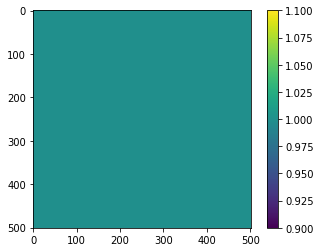

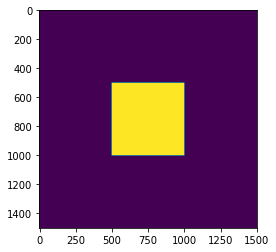

In [23]:
beam.generate_profile(pixel_size=pixel_size, lens_type=Lens.LensType.Spherical)

# generate the lens profile
if beam_spread is BeamSpread.Plane:
    if beam_shape is BeamShape.Circular:
        beam.profile = (beam.profile != 0) * 1
    elif beam_shape is BeamShape.Square:
        beam.profile = np.ones(shape=beam.profile.shape)
    elif beam_shape is BeamShape.Rectangular:
        beam.profile = np.zeros(shape=beam.profile.shape)
        # make sure to fill out in the correct order, otherwise this creates a square
        if beam_height > beam_width:
            profile_width = int(beam_width/pixel_size/2)
            beam.profile[beam.profile.shape[0]//2-profile_width:beam.profile.shape[0]//2+profile_width, :] = 1
        elif beam_width > beam_height:
            profile_height = int(beam_height/pixel_size/2)
            beam.profile[:, beam.profile.shape[0]//2-profile_height:beam.profile.shape[0]//2+profile_height] = 1
# diverging/converging cases
else: 
    # calculate the equivalent focal distance of the required convergence angle
    focal_distance = focal_distance_from_theta(beam=beam, theta=theta)
    # calculate and set the height of the apertures 'virtual' lens, re-generate the profile with new height
    beam.height = height_from_focal_distance(beam, output_medium=output_medium, focal_distance=focal_distance)
    print(theta)
    print(focal_distance)
    print(beam.height)
    beam.generate_profile(pixel_size=pixel_size, lens_type=Lens.LensType.Spherical)

    if beam_spread is BeamSpread.Diverging:
        beam.invert_profile()
        beam.profile = (beam.profile < beam.height) * beam.profile

# set up the part of the lens square that isn't the lens for aperturing
non_lens_profile = beam.profile == 0 
aperturing_value = -1e-9
beam.profile[non_lens_profile] = aperturing_value

plt.imshow(beam.profile)
plt.colorbar()
plt.show()

# calculate padding parameters
pad_width = (int(sim_width/pixel_size)-len(beam.profile))//2 + 1 
relative_position_y = int(beam_position[0]/pixel_size)
relative_position_x = int(beam_position[1]/pixel_size)

# pad the profile to the sim width (Top - Bottom - Left - Right)
beam.profile = np.pad(beam.profile, ((pad_width + relative_position_y, pad_width - relative_position_y),
                                             (pad_width + relative_position_x, pad_width - relative_position_x)))


# set up the sim padding to be apertured
beam.profile[:, :(pad_width + relative_position_x)] = aperturing_value
beam.profile[:, -(pad_width - relative_position_x):] = aperturing_value
beam.profile[:(pad_width + relative_position_y), :] = aperturing_value
beam.profile[-(pad_width - relative_position_y):, :] = aperturing_value

plt.imshow(beam.profile)
plt.show()


In [24]:

start_distance = 0

# If you just want the source to be a certain distance away:
if distance_mode is DistanceMode.Direct or beam_spread is BeamSpread.Plane:
    finish_distance = source_aperture_distance

elif distance_mode is DistanceMode.Focal:
    finish_distance = focal_distance

# if you want the beam to converge/diverge to a specific width
elif distance_mode is DistanceMode.Width:
    final_beam_radius = final_beam_width/2
    if beam_spread is BeamSpread.Converging:
        finish_distance = focal_distance - (final_beam_radius/np.tan(theta))
    else:
        finish_distance = ((final_beam_radius-(beam.diameter/2))/np.tan(theta))
else:
    raise ValueError('DistanceMode set incorrectly')

print(finish_distance)

0.02


[0.000e+00 1.000e-06 2.000e-06 ... 1.498e-03 1.499e-03 1.500e-03]
[0.000e+00 1.000e-06 2.000e-06 ... 1.498e-03 1.499e-03 1.500e-03]
[[0.000e+00 1.000e-06 2.000e-06 ... 1.498e-03 1.499e-03 1.500e-03]
 [1.000e-06 2.000e-06 3.000e-06 ... 1.499e-03 1.500e-03 1.501e-03]
 [2.000e-06 3.000e-06 4.000e-06 ... 1.500e-03 1.501e-03 1.502e-03]
 ...
 [1.498e-03 1.499e-03 1.500e-03 ... 2.996e-03 2.997e-03 2.998e-03]
 [1.499e-03 1.500e-03 1.501e-03 ... 2.997e-03 2.998e-03 2.999e-03]
 [1.500e-03 1.501e-03 1.502e-03 ... 2.998e-03 2.999e-03 3.000e-03]]


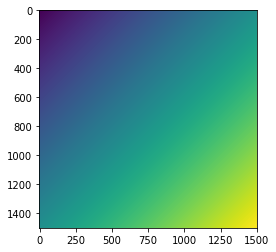

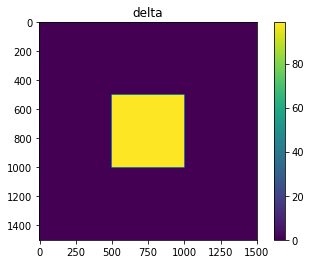

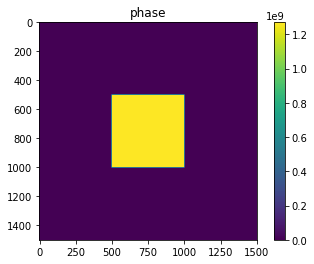

TypeError: Non-Lens passed

In [25]:
tilt_enabled = True
xtilt = 45 #-45
ytilt = 45

# regular delta calculation
delta = (beam.medium.refractive_index-output_medium.refractive_index) * beam.profile

# tilt the beam
if tilt_enabled:
    x = np.arange(len(beam.profile))*pixel_size
    y = np.arange(len(beam.profile))*pixel_size

    x_tilt = x * np.tan(np.deg2rad(xtilt))
    y_tilt = y * np.tan(np.deg2rad(ytilt))


    # modify the optical path of the light based on tilt
    # delta = delta + np.outer(x, y)
    # delta = delta + x * np.tan(np.deg2rad(xtilt))
    delta = delta + np.add.outer(y * np.tan(np.deg2rad(ytilt)), -x * np.tan(np.deg2rad(xtilt)))

# regular phase calculation
phase = (2 * np.pi * delta / sim_wavelength) #% (2 * np.pi)

# plt.imshow(np.outer(x, y))

# plt.imshow(np.log(delta+1e-9))
# plt.imshow(np.log(delta))
# plt.imshow(phase)
# plt.colorbar()

print(x_tilt)
print(y_tilt)
print(np.add.outer(x_tilt, y_tilt))
plt.imshow(np.add.outer(y_tilt, x_tilt))
plt.show()

plt.imshow(delta)
plt.colorbar()
plt.title("delta")
plt.show()

plt.imshow(phase)
plt.title("phase")
plt.colorbar()
plt.show()

# utils.plot_lens_profile_slices(beam)
# plt.show()
print(beam.profile.shape)

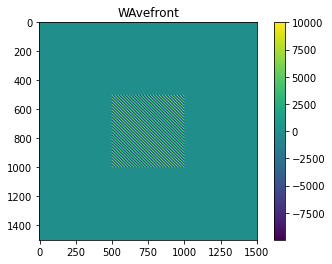

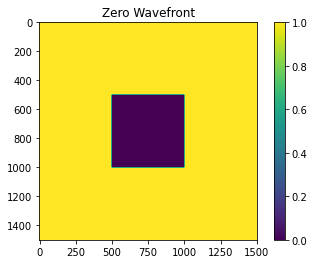

In [26]:
# regular wavefront calculation
wavefront = amplitude * np.exp(1j * phase)

# asymmetric aperturing (apply aperture mask)
wavefront[beam.profile==aperturing_value] = 0 + 0j

plt.imshow(wavefront.real)
plt.title("WAvefront")
plt.colorbar()
plt.show()

plt.imshow(wavefront.real == 0)
plt.colorbar()
plt.title("Zero Wavefront")
plt.show()

# regular wavefront FFT
wavefront = fftpack.fft2(wavefront)


In [20]:
# # regular wavefront calculation
# original_wavefront = amplitude * np.exp(1j * phase)
# plt.imshow(phase)
# # asymmetric aperturing (apply aperture mask)
# original_wavefront[beam.profile==aperturing_value] = 1000 + 0j
# plt.figure()
# plt.imshow(original_wavefront.real)
# # plt.imshow(original_wavefront.real)
# plt.colorbar()
# plt.show()

In [18]:
# regular frequency array creation
frequency_array = Simulation.generate_sq_freq_arr(sim_profile=beam.profile, pixel_size=pixel_size)

n_slices_1 = 20

sim = np.ones(shape=((n_slices_1), len(beam.profile[0]), len(beam.profile[1])))
distances_1 = np.linspace(start_distance, finish_distance, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array) / output_medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft2(prop_1 * wavefront)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)
    
    sim[i] = np.round(output, 10)



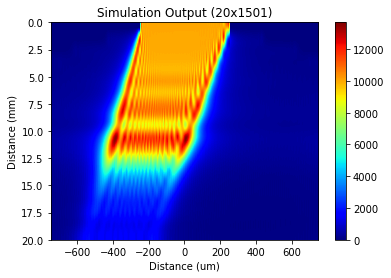

0
0.02


In [27]:
sim_to_show = sim[:, sim.shape[1]//2, :]

utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
plt.show()

print(start_distance)
print(finish_distance)


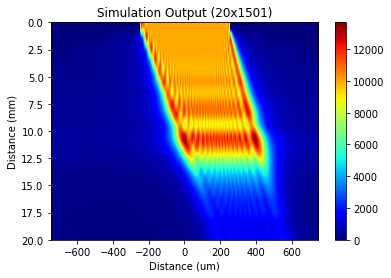

In [22]:
sim_to_show = sim[:, :, sim.shape[-1]//2]

utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
plt.show()

<Figure size 432x288 with 0 Axes>

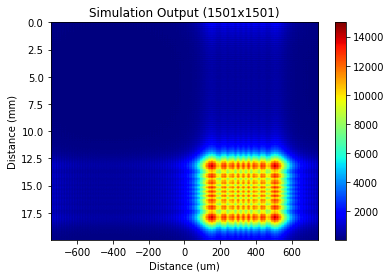

In [762]:
sim_to_show = sim[-1]
plt.figure()
utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
plt.show()

<Figure size 432x288 with 0 Axes>

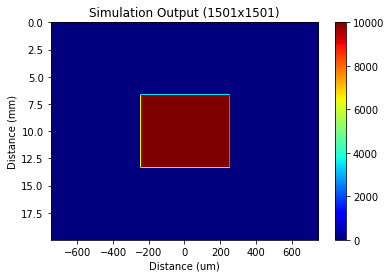

<Figure size 432x288 with 0 Axes>

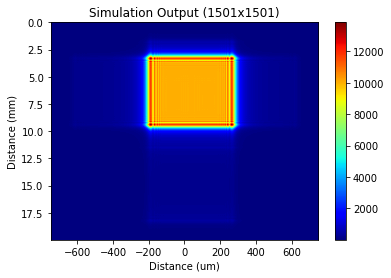

<Figure size 432x288 with 0 Axes>

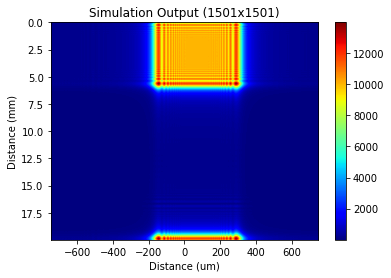

<Figure size 432x288 with 0 Axes>

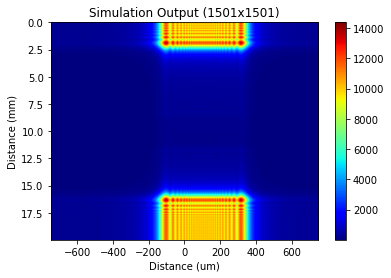

<Figure size 432x288 with 0 Axes>

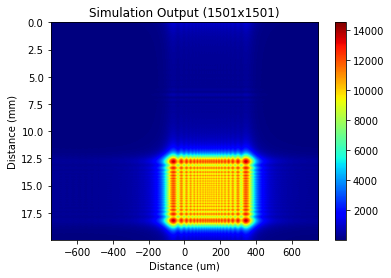

<Figure size 432x288 with 0 Axes>

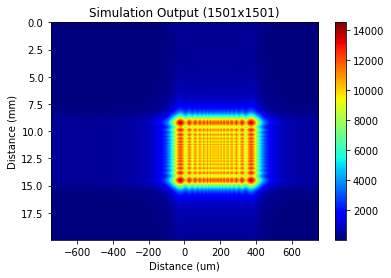

<Figure size 432x288 with 0 Axes>

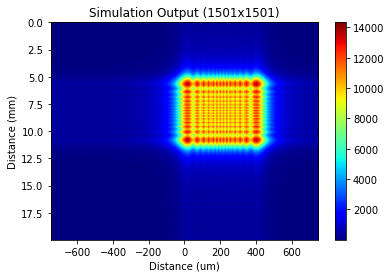

<Figure size 432x288 with 0 Axes>

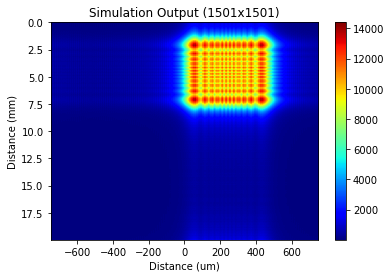

<Figure size 432x288 with 0 Axes>

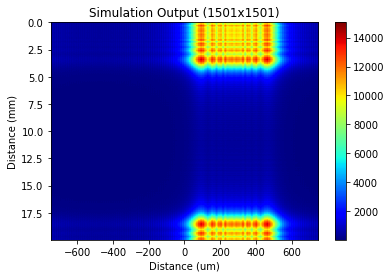

<Figure size 432x288 with 0 Axes>

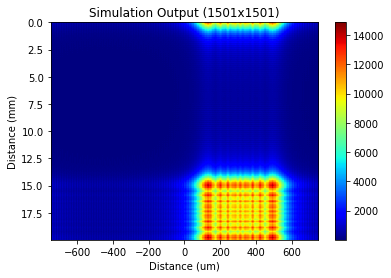

In [763]:
for sim_to_show in sim[::2]:
    plt.figure()
    utils.plot_simulation(sim_to_show, sim_to_show.shape[1], sim_to_show.shape[0], pixel_size, start_distance, finish_distance)
    plt.show()

### Error Checking

In [ ]:
# ERROR CHECKING #
# quick check on aperture validity
if (relative_position_x + beam_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
if (relative_position_y + beam_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
# if using diverging beam spread and DistanceMode.Width, the aperture must be smaller than the final_width
if beam_spread is BeamSpread.Diverging and distance_mode is DistanceMode.Width and final_beam_width < beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')
# likewise for using converging beam spread and DistanceMode.Width, the aperture must be larger than the final_width
if beam_spread is BeamSpread.Converging and distance_mode is DistanceMode.Width and final_beam_width > beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')


### Aperture/Beam definition

In [ ]:
# Beam settings chosen by user
beam_width = 400e-6
# position given relative to optical axis
beam_position = -100e-6

# this is selected by DistanceMode flag in config
distance_mode = DistanceMode.Width

# type of beam spread
beam_spread = BeamSpread.Converging

# calculate theta for non plane waves
if beam_spread is not BeamSpread.Plane:
    # Theta can either be specified directly, or by numerical aperture (config flag probably)
    theta = np.deg2rad(10) 
    # OR
    theta = theta_from_NA(numerical_aperture=0.4, output_medium=output_medium)

# perpendicular distance of source from the first lens can be defined directly (aperture distance) 
# or based on a desired beam width at the lens plane 
source_aperture_distance = 2000e-6
final_beam_width = 80e-6
if beam_spread is BeamSpread.Plane:
    final_beam_width = beam_width

# set tilt enabled based off flag
tilt_enabled = True
tilt_angle = np.deg2rad(85)

# Default beam specifications
aperture = Lens.Lens(
    diameter=beam_width,
    height=0.,
    exponent=2,
    medium=Lens.Medium(100)
)

# ERROR CHECKING #
# quick check on aperture validity
if (beam_position + beam_width/2) > sim_width:
    raise ValueError('Aperture cannot exist outside of simulation') 
# if using diverging beam spread and DistanceMode.Width, the aperture must be smaller than the final_width
if beam_spread is BeamSpread.Diverging and distance_mode is DistanceMode.Width and final_beam_width < beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')
# likewise for using converging beam spread and DistanceMode.Width, the aperture must be larger than the final_width
if beam_spread is BeamSpread.Converging and distance_mode is DistanceMode.Width and final_beam_width > beam_width:
    raise ValueError('Diverging beam final width cannot be smaller than aperture width')


#### Calculation of Convergence/Divergence

In [ ]:
if beam_spread is not BeamSpread.Plane:
    # calculate the equivalent focal distance of the required convergence angle
    focal_distance = focal_distance_from_theta(aperture=aperture, theta=theta)

    # calculate and set the height of the apertures 'virtual' lens, re-generate the profile with new height
    aperture.height = height_from_focal_distance(aperture, output_medium=output_medium, focal_distance=focal_distance)
    
    printing = False
    if printing:
        # Just some debugging prints, can remove if you want
        print(f'Angle of convergence: {np.rad2deg(theta)}')
        print(f'Focal distance wanted: {round(focal_distance*1e3, 3)}mm')
        print(f'Aperture height: {round(aperture.height*1e6, 3)}um')
        print(f'New Focal Distance: {round(Simulation.calculate_equivalent_focal_distance(aperture, output_medium)*1e3, 3)}mm')

aperture.generate_profile(pixel_size=pixel_size)

# possibly just invert lens
if beam_spread is BeamSpread.Diverging:
    aperture.profile = -aperture.profile + np.max(aperture.profile) 

### Calculation of aperture position and padding

In [ ]:

# calculate the relative position of the aperture in pixels
relative_position = int(beam_position/pixel_size)

# pad the aperture to the sim width
# plus one here is to make it 10001, not 9999
pad_width = (int(sim_width/pixel_size)-len(aperture.profile))//2 + 1 

# update the aperture profile
aperture.profile = np.pad(aperture.profile, (pad_width+relative_position, pad_width-relative_position), 'constant', constant_values=(0))
plt.plot(aperture.profile)

#### Calculation of Propagation Distance

In [ ]:
# Start distance of beam always = 0
start_distance = 0

# If you just want the source to be a certain distance away:
if distance_mode is DistanceMode.Direct or beam_spread is BeamSpread.Plane:
    finish_distance = source_aperture_distance

# if you want the beam to converge/diverge to a specific width
elif distance_mode is DistanceMode.Width:
    beam_radius = final_beam_width/2
    if beam_spread is BeamSpread.Converging:
        finish_distance = focal_distance - (beam_radius/np.tan(theta))
    else:
        finish_distance = ((beam_radius-(aperture.diameter/2))/np.tan(theta))
else:
    raise ValueError('DistanceMode set incorrectly')

### Delta, Tilt, Phase

In [ ]:
# regular delta calculation
delta = (aperture.medium.refractive_index-output_medium.refractive_index) * aperture.profile

# tilt the beam
if tilt_enabled:
    x = np.arange(len(aperture.profile))*pixel_size
    # modify the optical path of the light based on tilt
    delta = delta + x * np.tan(np.deg2rad(15))

# regular phase calculation
phase = (2 * np.pi * delta / sim_wavelength)# % (2 * np.pi)

### Wavefront Calculation

In [ ]:
# regular wavefront calculation
wavefront = amplitude * np.exp(1j * phase)

# asymmetric aperturing (apply aperture mask)
wavefront[:pad_width + relative_position] = 0 + 0j
wavefront[-(pad_width - relative_position):] = 0 + 0j

# regular wavefront FFT
wavefront = fftpack.fft(wavefront)

### Simulation

In [ ]:
# regular frequency array creation
frequency_array = Simulation.generate_squared_frequency_array(n_pixels=len(aperture.profile), pixel_size=pixel_size)

n_slices_1 = 100

sim = np.ones(shape=((n_slices_1), len(aperture.profile)))
distances_1 = np.linspace(start_distance, finish_distance, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array) / output_medium.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim[i] = np.round(output, 10)


utils.plot_simulation(sim, sim.shape[1], sim.shape[0], pixel_size, start_distance, finish_distance)
plt.show()